#### 1. Import and clean data

In [1]:
from io import open
import glob
import os

files_path = 'data/names/*.txt'
def find_files(path): return(glob.glob(path))

print(find_files(files_path))


['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Hausa.txt', 'data/names\\Igbo.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt', 'data/names\\Yoruba.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#Turn unicode strings to ASCII
def unicode_to_ascii(s):
	return ''.join(
		char for char in unicodedata.normalize('NFD', s)
		if unicodedata.category(char) != 'Mn' and char in all_letters
	)

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
category_words = {}
all_categories = []

# read a file and split it into lines
def read_words(file_name):
	words = open(file_name, encoding='utf-8').read().strip().split('\n')
	return[unicode_to_ascii(word) for word in words]

for file_name in find_files(files_path):
	category = os.path.splitext(os.path.basename(file_name))[0]
	all_categories.append(category)
	words = read_words(file_name)
	category_words[category] = words

n_categories = len(all_categories)

print(category_words['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


#### 2. Convert words to tensors

In [4]:
import torch
def letter_index(letter):
	return all_letters.find(letter)

def letter_to_tensor(letter):
	tensor = torch.zeros(1, n_letters)
	tensor[0][letter_index(letter)] = 1
	return tensor

def word_to_tensor(word):
	tensor = torch.zeros(len(word), 1, n_letters)
	for li, letter in enumerate(word):
		tensor[li][0][letter_index(letter)] = 1
	return tensor

print(letter_index('K'))
print(letter_to_tensor('a'))
print(word_to_tensor('abc').size())

36
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([3, 1, 57])


#### 3. RNN Network design

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
class RNN(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(RNN, self).__init__()
		self.hidden_size = hidden_size
		
		self.i2h = nn.Linear(input_size, hidden_size)
		self.h2h = nn.Linear(hidden_size, hidden_size)
		self.h2o = nn.Linear(hidden_size, output_size)
		self.softmax = nn.LogSoftmax(dim=1)
		
	def forward(self, input, hidden):
		hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
		output = self.h2o(hidden)
		output = self.softmax(output)
		return output, hidden
	
	def init_hidden(self):
		return torch.zeros(1, self.hidden_size)
	
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(summary(rnn))

Layer (type:depth-idx)                   Param #
RNN                                      --
├─Linear: 1-1                            7,424
├─Linear: 1-2                            16,512
├─Linear: 1-3                            2,709
├─LogSoftmax: 1-4                        --
Total params: 26,645
Trainable params: 26,645
Non-trainable params: 0


In [6]:
# test network
input = word_to_tensor('Hafiz')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.1649, -3.1294, -3.0618, -3.0530, -3.1604, -3.1914, -2.9375, -3.0571,
         -3.0268, -3.0332, -2.8855, -2.8868, -2.9682, -3.1257, -2.9849, -2.9785,
         -3.0497, -3.1642, -2.9719, -3.0379, -3.1515]],
       grad_fn=<LogSoftmaxBackward0>)


#### 4. Training

In [7]:
# Get propability category from output tensor
def category_from_output(output):
	top_num, top_num_idx = output.topk(1)
	category_i = top_num_idx[0].item()
	return all_categories[category_i], category_i

print(category_from_output(output))

('Irish', 10)


In [8]:
# randomly select samples from training set

import random

def random_choice(length):
	return length[random.randint(0, len(length) - 1)]

def random_training_example():
	category = random_choice(all_categories)
	word = random_choice(category_words[category])
	category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
	word_tensor = word_to_tensor(word)
	return category, word, category_tensor, word_tensor

for i in range(10):
	category, word, category_tensor, word_tensor = random_training_example()
	print('category:', category, '\t|\t word:', word)

category: French 	|	 word: Sauvage
category: Arabic 	|	 word: Sabbagh
category: Czech 	|	 word: Macikova
category: Dutch 	|	 word: Roijakker
category: Japanese 	|	 word: Iriye
category: Yoruba 	|	 word: Ogunkolade
category: Russian 	|	 word: Abuhoff
category: Chinese 	|	 word: AuYong
category: Greek 	|	 word: Pispinis
category: Polish 	|	 word: Sowka


In [9]:
criterion = nn.NLLLoss()
learning_rate = 5e-3

In [10]:
def train(category, word_tensor):
	hidden = rnn.init_hidden()
	
	rnn.zero_grad()
	
	for i in range(word_tensor.size()[0]):
		output, hidden = rnn(word_tensor[i], hidden)
	
	loss = criterion(output, category_tensor)
	loss.backward()

	# Add parameters' gradients to their values, multiplied by learning rate
	for p in rnn.parameters():
		p.data.add_(p.grad.data, alpha=-learning_rate)

	return output, loss.item()

In [11]:
import time
import math

n_iters = 10000
print_every = 5*n_iters//100
plot_every = print_every//5

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    sec = now - since
    min = math.floor(sec/60)
    sec -= min * 60
    return '%dm %ds' % (min, sec)

start = time.time()

for iter in range(1, n_iters+1):
    category, word, category_tensor, word_tensor = random_training_example()
    output, loss = train(category_tensor, word_tensor)
    current_loss += loss
    
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, word, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

model_path = 'models/name_classifier.pt'
torch.save(rnn.state_dict(), model_path)

500 5% (0m 1s) 3.1165 Tikhobaev / German ✗ (Russian)
1000 10% (0m 3s) 3.1211 D'cruze / Arabic ✗ (Portuguese)
1500 15% (0m 5s) 2.8974 Aswad / Czech ✗ (Arabic)
2000 20% (0m 6s) 3.0056 Bakanchuk / Polish ✗ (Russian)
2500 25% (0m 8s) 2.9426 Palumbo / Yoruba ✗ (Italian)
3000 30% (0m 9s) 2.7603 Baba / Japanese ✗ (Hausa)
3500 35% (0m 11s) 2.8057 Gledhill / German ✗ (English)
4000 40% (0m 12s) 2.8900 Meeuwes / Greek ✗ (Dutch)
4500 45% (0m 14s) 1.7294 Xiao / Chinese ✓
5000 50% (0m 15s) 3.1548 Rios / Korean ✗ (Portuguese)
5500 55% (0m 17s) 2.5672 Nosek / Czech ✗ (Polish)
6000 60% (0m 18s) 2.9644 Poggio / Portuguese ✗ (Italian)
6500 65% (0m 20s) 2.2042 Ganim / Arabic ✓
7000 70% (0m 21s) 1.6489 Mateus / Portuguese ✓
7500 75% (0m 23s) 1.7522 Morrison / Scottish ✓
8000 80% (0m 25s) 1.6643 anjuma / Hausa ✓
8500 85% (0m 26s) 2.8192 Fonseca / Yoruba ✗ (Portuguese)
9000 90% (0m 27s) 1.0995 Ding / Chinese ✓
9500 95% (0m 29s) 1.4086 Reuter / German ✓
10000 100% (0m 30s) 3.8485 Ego / Vietnamese ✗ (Igbo)


In [12]:
rnn = RNN(n_letters, n_hidden, n_categories)
rnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

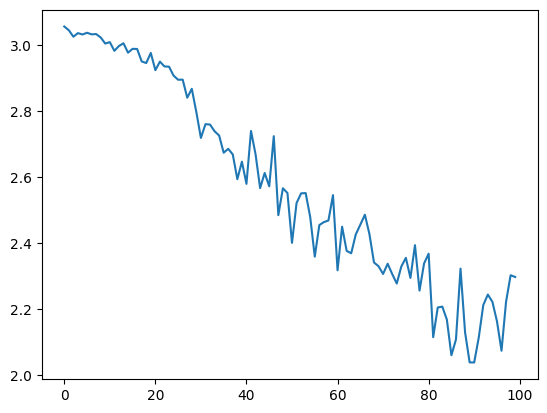

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#### 5. Evaluation

C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_9960\3897230354.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation = 90)
C:\Users\AttahiruJibril\AppData\Local\Temp\ipykernel_9960\3897230354.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


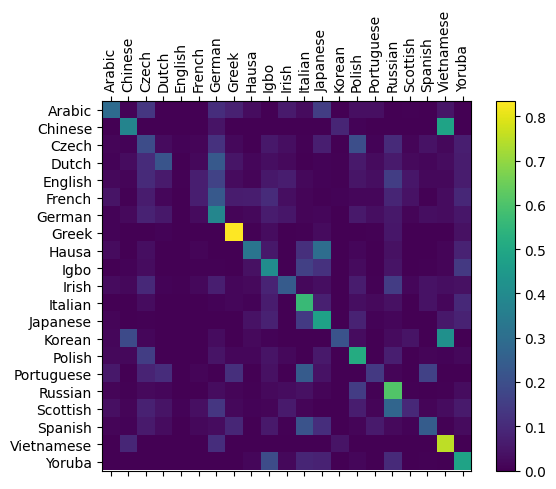

In [14]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# return an output give a word
def evaluate(word_tensor):
	hidden = rnn.init_hidden()
	
	for i in range(word_tensor.size()[0]):
		output, hidden = rnn(word_tensor[i], hidden)
	
	return output

#record correct guesses from examples
for i in range(n_confusion):
    category, word, category_tensor, word_tensor = random_training_example()
    output = evaluate(word_tensor)
    guess, guess_idx = category_from_output(output)
    category_idx = all_categories.index(category)
    confusion[category_idx][guess_idx] += 1
    
# normalize confusion
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()

#plot 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [15]:
def predict(input_word, n_predictions=3):
    print('\n> %s' % input_word)
    with torch.no_grad():
        output = evaluate(word_to_tensor(input_word))
        top_pred, top_pred_idx = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            pred = top_pred[0][i].item()
            category_idx = top_pred_idx[0][i].item()
            print('(%.2f) %s' % (pred, all_categories[category_idx]))
            predictions.append([pred, all_categories[category_idx]])


predict('Jackson')
predict('Dovesky')
predict('Derrick')


> Jackson
(-1.28) Russian
(-1.66) Scottish
(-2.09) Irish

> Dovesky
(-0.85) Polish
(-1.75) Russian
(-2.20) Czech

> Derrick
(-2.06) Czech
(-2.10) Polish
(-2.37) English
